# Planet: Understanding the Amazon from Space

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import os

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
import keras

Using TensorFlow backend.


In [0]:
from pathlib import Path

### Data Collection

In [0]:
!mkdir .kaggle

In [0]:
from google.colab import files
files.upload()

In [0]:
!cp kaggle.json  ~/.kaggle/

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

### Downloading the dataset

In [0]:
path = Path('planet/')

In [0]:
path.mkdir(parents=True, exist_ok=True)

###### Download and Extract the data fils

In [0]:
# download and unzip train-jpg
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}
!7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

 97% 582M/600M [00:05<00:00, 58.4MB/s]
100% 600M/600M [00:06<00:00, 104MB/s] 


In [0]:
# download and unzip test-jpg
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path.as_posix()}

100% 603M/603M [00:05<00:00, 124MB/s]
100% 603M/603M [00:05<00:00, 110MB/s]


In [0]:
# download and unzip test-jpg-additional
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}
!7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path.as_posix()}

 93% 283M/304M [00:04<00:00, 61.5MB/s]
100% 304M/304M [00:04<00:00, 71.1MB/s]


###### Download and Extract the metadata files

In [0]:
# download and unzip csv files
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}
!unzip -q -n {path}/train_v2.csv.zip -d {path}


  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 50.3MB/s]


In [0]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f test_v2_file_mapping.csv -p {path}
! unzip -q -n {path}/test_v2_file_mapping.csv.zip -d {path}


  0% 0.00/110k [00:00<?, ?B/s]
100% 110k/110k [00:00<00:00, 33.7MB/s]


In [0]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f sample_submission_v2.csv -p {path}
! unzip -q -n {path}/sample_submission_v2.csv.zip -d {path}


  0% 0.00/154k [00:00<?, ?B/s]
100% 154k/154k [00:00<00:00, 56.3MB/s]


# FastAI

In [0]:
import fastai.vision as fv

## 1.1 Data Preparation

In [0]:
train_df = fv.pd.read_csv(path/'train_v2.csv')
sample_df = fv.pd.read_csv(path/'sample_submission_v2.csv')

In [0]:
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
sample_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [0]:
# data augmentation
tfms = fv.get_transforms(flip_vert=True, max_warp=0.)

In [0]:
# loading the data
fv.np.random.seed(42)
train_src = (fv.ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg').split_by_rand_pct(0.2).label_from_df(label_delim=' '))

In [0]:
# databunch and normalization(normalization helps to converge faster)
data = (train_src.transform(tfms, size=256).databunch().normalize(fv.imagenet_stats))

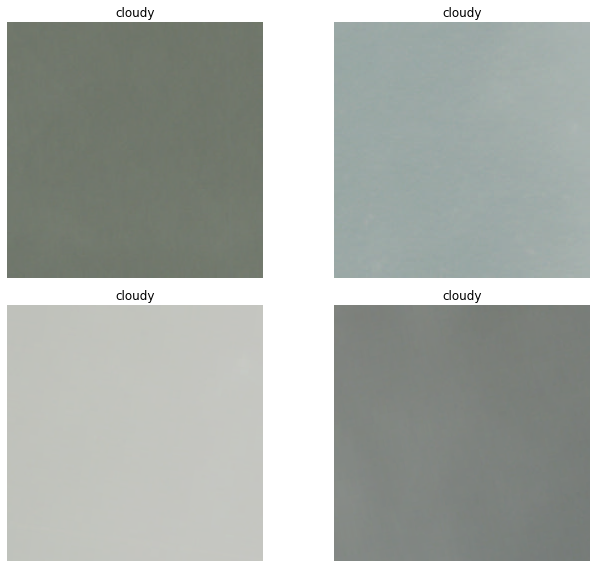

In [0]:
data.show_batch(rows=2, figsize=(10, 8))

## 1.2 Classification Model (what we call learner in FastAI)


In [0]:
# we will use densenet CNN architecture for the classification
arch = fv.models.densenet121

In [0]:
# partial function creates the  function on the top of existing functions(passed as arguement in the partial function)
acc = fv.partial(fv.accuracy_thresh, thresh=0.2)
f_score = fv.partial(fv.fbeta, thresh=0.2) # f2_score will be evaluated in the contest

In [0]:
model = fv.create_cnn(data, arch, metrics=[acc, f_score], model_dir='/kaggle/working/')

#### Let's train the model

In [0]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


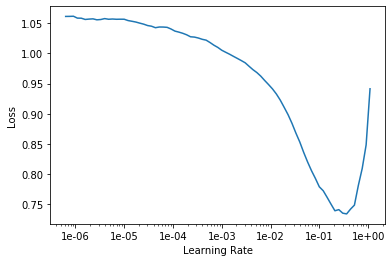

In [0]:
model.recorder.plot()

In [0]:
1e-0

1.0

In [0]:
# from the above plot we can see the Loss is minimum at lr=0.1
lr = 0.1

In [0]:
model.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.202152,0.464958,0.937652,0.871080,11:35
1,0.144719,0.129183,0.953690,0.900993,11:29
2,0.104333,0.324488,0.952113,0.921412,11:28


In [0]:
model.save('stage-1')

In [0]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


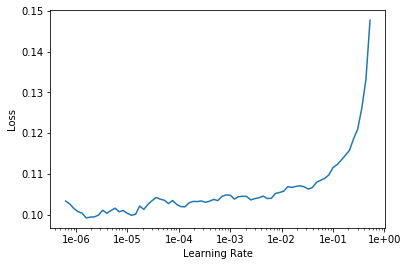

In [0]:
model.recorder.plot()

In [0]:
model.unfreeze()

In [0]:
model.fit_one_cycle(2, max_lr=slice(1e-6, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.107526,0.113091,0.952818,0.917951,14:19
1,0.097361,0.143279,0.956342,0.923129,14:20


In [0]:
model.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


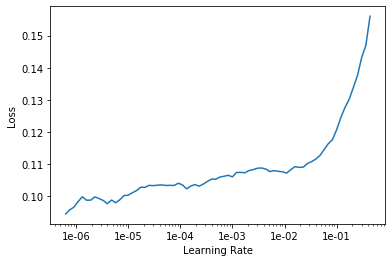

In [0]:
model.recorder.plot()

In [0]:
model.save('stage-')

In [0]:
model.unfreeze()

In [0]:
model.fit_one_cycle(2, max_lr=slice(1e-6))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.105813,0.095008,0.953167,0.920129,14:09
1,0.103227,0.094880,0.952796,0.919473,14:12


In [0]:
model.save('stage-5')

In [0]:
model.export('/kaggle/working/export.pkl',destroy=True)

In [0]:
model.export()

## 2.1 Data Pipeline

In [0]:
train_df = pd.read_csv(path/'train_v2.csv')
test_df = pd.read_csv(path/'test_v2_file_mapping.csv')
sample_df = pd.read_csv(path/'sample_submission_v2.csv')

In [0]:
train_df.head(3)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary


In [0]:
test_df.head(2)

,old,new
0,file_4158.tif,file_18830.tif
1,file_1668.tif,file_19164.tif


In [0]:
# it seems like test_df is of no use

In [0]:
sample_df.head(3)

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water


### One hot vector notation of the tags

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer

In [0]:
train_tags = train_df.tags

In [0]:
mlb = MultiLabelBinarizer()

In [0]:
one_hot = mlb.fit_transform(train_tags_)

In [0]:
one_hot.shape

(40479, 17)

In [0]:
mlb.classes_


array(['agriculture', 'artisinal_mine', 'bare_ground', 'blooming',
       'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation',
       'habitation', 'haze', 'partly_cloudy', 'primary', 'road',
       'selective_logging', 'slash_burn', 'water'], dtype=object)

In [0]:
train_df = pd.concat([train_df, pd.DataFrame(one_hot, columns=mlb.classes_)], axis=1)

In [0]:
train_df.shape

(40479, 19)

In [0]:
train_df.tail(6)

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
40473,train_40473,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0
40474,train_40474,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
40475,train_40475,cloudy,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
40476,train_40476,agriculture clear primary,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
40477,train_40477,agriculture clear primary road,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
40478,train_40478,agriculture cultivation partly_cloudy primary,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0


In [0]:
# save this into the memory we might need it later(once the session terminates)
train_df.to_csv('train_v2_one_hot.csv')

In [0]:
# move the above files on drive
!cp train_v2_one_hot.csv  drive/My\ Drive/

### Building the pipeline

In [0]:
if not os.path.isdir('planet/train'):
  os.mkdir('planet/train')

In [0]:
if not os.path.isdir('planet/test'):
  os.mkdir('planet/test')

In [0]:
if not os.path.isdir('planet/additional-test'):
  os.mkdir('planet/additional-test')

In [0]:
!mv planet/train-jpg/ planet/train/
!mv planet/test-jpg/  planet/test/
!mv planet/test-jpg-additional/ planet/additional-test/

#### Directory Structure
planet
- train
 - train-jpg
- test
 - test-jpg
- additional-test
 - test-jpg-additional

In [0]:
df = pd.read_csv("planet/train_v2.csv")

In [0]:
df['tags'] = df["tags"].apply(lambda x:x.split(" "))

In [0]:
df.head(1)

,image_name,tags
0,train_0,"[haze, primary]"


In [0]:
df['image_name'] = df.image_name.apply(lambda x:x+'.jpg')

In [0]:
df.head()

,image_name,tags
0,train_0.jpg,"[haze, primary]"
1,train_1.jpg,"[agriculture, clear, primary, water]"
2,train_2.jpg,"[clear, primary]"
3,train_3.jpg,"[clear, primary]"
4,train_4.jpg,"[agriculture, clear, habitation, primary, road]"


In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
train_datagen = val_datagen = test_datagen = additiona_test_datagen = ImageDataGenerator(rescale=1./255.)

In [0]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=df[1000:],
    directory="./planet/train/train-jpg/",
    x_col="image_name",
    y_col="tags",
    batch_size=32,
    seed=42,
    shuffle=True,
)

Found 39479 validated image filenames belonging to 17 classes.


In [0]:
val_gen = val_datagen.flow_from_dataframe(
    dataframe=df[:1000],
    directory="./planet/train/train-jpg/",
    x_col="image_name",
    y_col="tags",
    batch_size=32,
    seed=42,
    shuffle=False,
)

Found 1000 validated image filenames belonging to 17 classes.


## 2.2 Classification Model

In [0]:
!pip install keras_efficientnets

In [0]:
from keras_efficientnets import EfficientNetB4

In [0]:
efficient = EfficientNetB0((256, 256, 3), include_top=False, weights='imagenet')

In [0]:
model_archive = efficient

### Keras functional API

In [0]:
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.models import *

In [0]:
new_layer_1 = GlobalAveragePooling2D()(efficient.output)
new_layer_2 = Dropout(0.25)(new_layer_1)
new_layer_3 = Dense(512, activation='relu')(new_layer_2)
new_layer_4 = Dense(256, activation='relu')(new_layer_3)
new_layer_5 = Dense(64, activation='relu')(new_layer_4)
final_layer = Dense(17, activation='sigmoid')(new_layer_5)

In [0]:
model = Model(inputs=efficient.input, outputs=final_layer)

In [0]:
# model.summary()

### Compilation and Training

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
train_steps = train_df.shape[0]-1000 /32
val_steps = 1000/32
epochs = 10


In [0]:
es = EarlyStopping(monitor='val_acc', min_delta=0.05, patience=5)
cp = ModelCheckpoint('model.h5', save_best_only=True, save_weights_only=True)

In [0]:
model.compile(optimizer='adam', loss=['binary_crossentropy'], metrics=['accuracy'])

In [0]:
model.fit_generator(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=epochs,
    callbacks=[es, cp]
)

Epoch 1/10
1234/1234 [==============================] - 900s 729ms/step - loss: 0.1052 - acc: 0.9604 - val_loss: 0.0938 - val_acc: 0.9648
Epoch 2/10
1234/1234 [==============================] - 866s 702ms/step - loss: 0.0944 - acc: 0.9639 - val_loss: 0.0931 - val_acc: 0.9626
Epoch 3/10
1234/1234 [==============================] - 867s 703ms/step - loss: 0.0887 - acc: 0.9660 - val_loss: 0.0942 - val_acc: 0.9657
Epoch 4/10
1234/1234 [==============================] - 867s 703ms/step - loss: 0.0844 - acc: 0.9674 - val_loss: 0.0966 - val_acc: 0.9666
Epoch 5/10
1234/1234 [==============================] - 868s 703ms/step - loss: 0.0797 - acc: 0.9691 - val_loss: 0.0982 - val_acc: 0.9634
Epoch 6/10
1234/1234 [==============================] - 868s 703ms/step - loss: 0.0749 - acc: 0.9712 - val_loss: 0.1040 - val_acc: 0.9626


In [0]:
model.load_weights('model.h5')

In [0]:
model.evaluate_generator(val_gen, len(val_gen))

[0.09306506431102753, 0.9626470384597778]

## 2.3 Model Evaluation

In [0]:
test_gen = test_datagen.flow_from_directory(directory='planet/test/',shuffle=False)


Found 40669 images belonging to 1 classes.


In [0]:
additional_test_gen = additiona_test_datagen.flow_from_directory(directory='planet/additional-test/', shuffle=False)

Found 20522 images belonging to 1 classes.


In [0]:
test_gen.reset()

In [0]:
additional_test_gen.reset()

In [0]:
pred_test = model.predict_generator(test_gen, steps=len(test_gen), verbose=1)

1271/1271 [==============================] - 211s 166ms/step


In [0]:
pred_additional_test = model.predict_generator(additional_test_gen, steps=len(additional_test_gen), verbose=1)

642/642 [==============================] - 103s 160ms/step


#### decode the prediction

In [0]:
pred_test_bool = (pred_test > 0.5).astype(int)
pred_additional_test_bool =  (pred_additional_test > 0.5).astype(int)

In [0]:
labels = train_gen.class_indices

In [0]:
idx_to_class = dict([(value, key) for key, value in labels.items()])

In [0]:
# combine the both predictions
preds = np.vstack((pred_test_bool, pred_additional_test_bool))


In [0]:
preds.shape

(61191, 17)

In [0]:
sample_df.shape

(61191, 2)

In [0]:
sample_df.head(3)

,image_name,tags
0,test_0,hello
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water


In [0]:
predicted_labels = mlb.inverse_transform(preds)

In [0]:
len(predicted_labels)

61191

In [0]:
for i in range(len(predicted_labels)):
  tag = ''
  for j in range(len(predicted_labels[i])):
    
    if len(tag) != 0:
      tag = tag + " " + predicted_labels[i][j]
    else:
      tag += predicted_labels[i][j]
    
  sample_df.tags[i] = tag

In [0]:
sample_df.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear cultivation primary water
4,test_4,agriculture clear primary road


## 2.4 Submission

In [0]:
sample_df.to_csv('submission.csv', index=False)

In [0]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {'submission.csv'} -m "My submission"

100% 2.19M/2.19M [00:04<00:00, 550kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space